# Logistic Regression with PCA

In this notebook we train a multiclass logistic regression classifier on image features, 
after applying PCA for dimensionality reduction. The dataset used is ArtBench-10, with 
the objective of classifying images by art style.  

We use RandomizedSearchCV to optimize key hyperparameters (`C` and `max_iter`).  

Finally, we evaluate the model’s performance on a held-out test set, reporting both the 
best hyperparameters and overall accuracy, as well as a per-class classification report 
to analyze results in more detail.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

DATA_DIR = "data/artbench-10"
IMAGE_SIZE = 64
BATCH_SIZE = 512
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
g = torch.Generator()
g.manual_seed(SEED)

We define a transform pipeline that resizes all images to the chosen input size 
and converts them into tensors so they can be processed by PyTorch.

In [2]:
resize_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

We create training and test datasets from the folder structure and wrap them in DataLoaders.  
Each batch returned by the dataloaders has the form (images, labels), where:

- images: a tensor of shape [batch_size, channels, height, width]
- labels: a tensor of shape [batch_size] with the class indices

We also print the class names, number of classes, and dataset sizes. The sample image shape 
confirms the resized format used in the pipeline.

In [3]:
train_ds = datasets.ImageFolder(root=f"{DATA_DIR}/train", transform=resize_tf)
test_ds  = datasets.ImageFolder(root=f"{DATA_DIR}/test",  transform=resize_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    generator=g,
)


test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    generator=g,
)

class_names = train_ds.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Train images: {len(train_ds)}")
print(f"Test images:  {len(test_ds)}")
print(f"Image shape: {train_ds[0][0].shape}")

Classes: ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']
Number of classes: 10
Train images: 50000
Test images:  10000
Image shape: torch.Size([3, 64, 64])


We display a few training images with their labels to quickly verify that the transform 
and loading process work as expected.

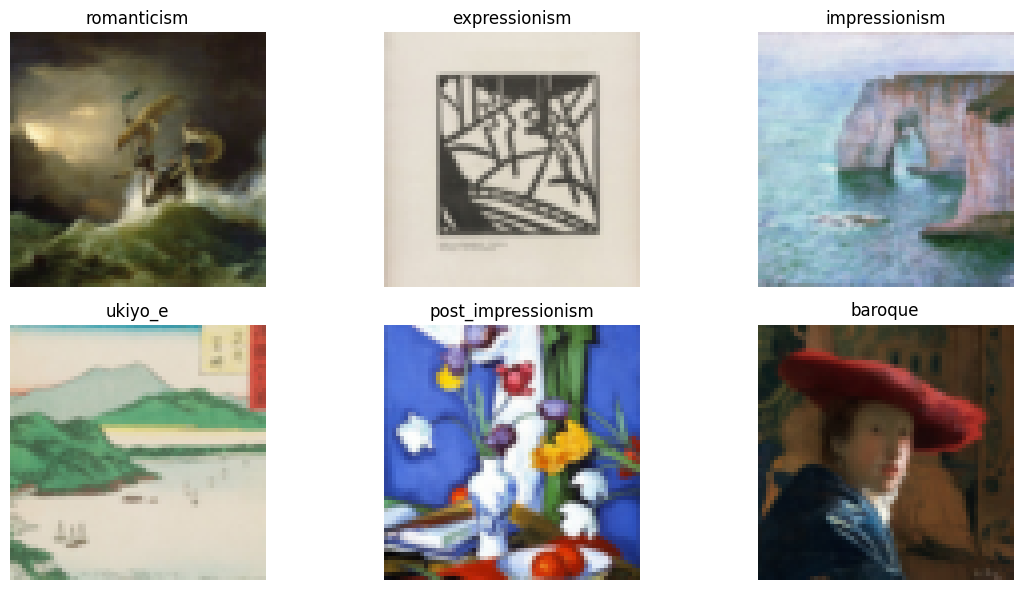

In [4]:
def show_batch(imgs, labels, class_names, n=6):
    imgs = imgs[:n]
    labels = labels[:n]
    plt.figure(figsize=(12, 6))
    for i, (img, lab) in enumerate(zip(imgs, labels)):
        npimg = img.numpy().transpose(1, 2, 0)  # CHW → HWC
        plt.subplot(2, 3, i + 1)
        plt.imshow(np.clip(npimg, 0, 1))
        plt.title(class_names[lab])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

imgs, labs = next(iter(train_loader))
show_batch(imgs, labs, class_names, n=6)

We fit an Incremental PCA transformation to reduce the dimensionality of the images.  
Given flattened image vectors of dimension $D = C \times H \times W$, in principle we could 
extract up to $\min(D, N)$ components ($N$ = number of samples). In practice, using such a 
large $K$ would be computationally too heavy, so we set $K_{\text{max}} = 1024$ as a 
reasonable upper bound for later experiments.  

A warm-up phase is needed so that the transformation can initialize with at least 
$K_{\text{max}}$ samples before the first partial fit. After this, Incremental PCA 
processes the dataset batch by batch, which is essential for ArtBench-10 since the full 
dataset in raw pixel form does not fit into memory at once.

In [5]:
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import joblib
import os

KMAX = 1024
RESULTS_DIR = "results/01_linear_models"
os.makedirs(RESULTS_DIR, exist_ok=True)
PCA_MODEL_PATH = os.path.join(RESULTS_DIR, f"ipca_artbench.pkl")

if os.path.exists(PCA_MODEL_PATH):
    print(f"Loading existing IncrementalPCA from {PCA_MODEL_PATH}")
    ipca = joblib.load(PCA_MODEL_PATH)

else:
    print("Fitting IncrementalPCA from scratch...")
    ipca = IncrementalPCA(n_components=KMAX)

    pbar = tqdm(total=len(train_loader), desc="Fitting IncrementalPCA")

    it = iter(train_loader)
    warm_X, n_seen = [], 0
    while n_seen < ipca.n_components:
        xb, _ = next(it)
        Xb = xb.flatten(1).cpu().numpy().astype(np.float32)
        warm_X.append(Xb)
        n_seen += Xb.shape[0]
        pbar.update(1)

    warm_X = np.concatenate(warm_X, axis=0)
    ipca.partial_fit(warm_X)
    pbar.set_postfix(seen=getattr(ipca, "n_samples_seen_", "?"))

    for xb, _ in it:
        Xb = xb.flatten(1).cpu().numpy().astype(np.float32)
        ipca.partial_fit(Xb)
        pbar.update(1)
        pbar.set_postfix(seen=getattr(ipca, "n_samples_seen_", "?"))

    pbar.close()

    joblib.dump(ipca, PCA_MODEL_PATH)
    print(f"Saved IncrementalPCA to {PCA_MODEL_PATH}")

Loading existing IncrementalPCA from results/01_linear_models/ipca_artbench.pkl


In [6]:
ipca = joblib.load(PCA_MODEL_PATH)

print(type(ipca))
print(ipca.n_components_)
print(ipca.components_.shape)

<class 'sklearn.decomposition._incremental_pca.IncrementalPCA'>
1024
(1024, 12288)


We compute the reconstruction error curve of PCA for different numbers of components.  
For each batch, the data is projected into the PCA basis and then reconstructed using only 
the first $K$ components. The mean squared error (MSE) between the original data $X$ and 
its reconstruction $\hat{X}_K$ is accumulated:  

$$
\text{MSE}(K) = \frac{1}{N} \sum_{i=1}^N \| x_i - \hat{x}_{i,K} \|^2
$$

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

def mse_curve(loader, ipca, Ks):
    n_samples = 0
    total_sse = {K: 0.0 for K in Ks}

    pbar = tqdm(total=len(loader), leave=True)

    for xb, _ in loader:
        Xb = xb.flatten(1).cpu().numpy().astype(np.float32)  # [B, D]
        Z = ipca.transform(Xb)                               # [B, n_components]

        for K in Ks:
            Zt = Z.copy()
            Zt[:, K:] = 0.0
            Xh = ipca.inverse_transform(Zt)
            diff = Xb - Xh
            sse = (diff**2).sum(axis=1)
            total_sse[K] += sse.sum()

        n_samples += Xb.shape[0]
        pbar.update(1)

    pbar.close()
    return {K: total_sse[K] / n_samples for K in Ks}

In [8]:
Ks = list(range(0, (KMAX // 50) * 50 + 1, 50))
if Ks[-1] != KMAX:
    Ks.append(KMAX)

train_path = os.path.join(RESULTS_DIR, "pca_curve_train.npy")
test_path  = os.path.join(RESULTS_DIR, "pca_curve_test.npy")

if os.path.exists(train_path) and os.path.exists(test_path):
    print("Loading curves from disk...")
    L_train = np.load(train_path, allow_pickle=True).item()
    L_test  = np.load(test_path, allow_pickle=True).item()
else:
    print("Computing curves from scratch...")
    L_train = mse_curve(train_loader, ipca, Ks)
    L_test  = mse_curve(test_loader,  ipca, Ks)
    np.save(train_path, L_train)
    np.save(test_path,  L_test)
    print(f"Saved curves to {train_path} and {test_path}")

Loading curves from disk...


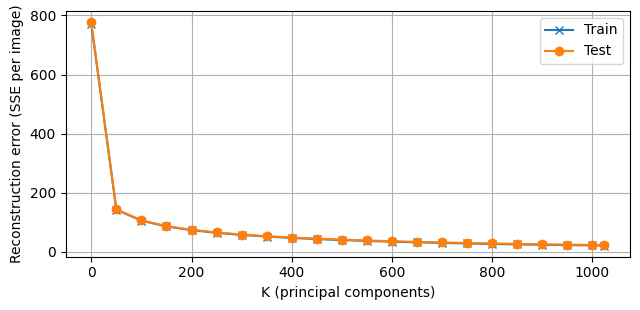

In [9]:
plt.figure(figsize=(6.5, 3.2))
plt.grid(True)
plt.plot(list(L_train.keys()), list(L_train.values()), '-x', label='Train')
plt.plot(list(L_test.keys()), list(L_test.values()),  '-o', label='Test')
plt.xlabel('K (principal components)')
plt.ylabel('Reconstruction error (SSE per image)')
plt.legend(); plt.tight_layout(); plt.show()

As we can see in the plot, the error drops sharply at the beginning and then levels off.  
Choosing $K = 400$ captures most variance while avoiding unnecessary dimensions.

We convert the dataloaders into matrices suitable for scikit-learn by projecting each 
image into the PCA space. Each image, originally of size $3 \times 64 \times 64$, is first 
flattened and then reduced to its coordinates in the first $K = 400$ principal components.  

This produces the training and test sets $(X, y)$ where $X$ contains the PCA features and 
$y$ the corresponding style labels.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import classification_report
import joblib

def dataloader_to_pca(loader, ipca, K):
    Xs, ys = [], []
    pbar = tqdm(total=len(loader), desc=f"Projecting to {K} PCs", leave=True)
    for xb, yb in loader:
        Xb = xb.flatten(1).cpu().numpy().astype(np.float32)   # [B, D]
        Zb = ipca.transform(Xb)[:, :K]                        # [B, K]
        Xs.append(Zb)
        ys.append(yb.cpu().numpy())
        pbar.update(1)
    pbar.close()
    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y

KSEL = 400
PCA_TRAIN = os.path.join(RESULTS_DIR, f"train_pca_{KSEL}.pkl")
PCA_TEST  = os.path.join(RESULTS_DIR, f"test_pca_{KSEL}.pkl")
LAB_TRAIN = os.path.join(RESULTS_DIR, "y_train_pca.pkl")
LAB_TEST  = os.path.join(RESULTS_DIR, "y_test_pca.pkl")

if all(os.path.exists(p) for p in [PCA_TRAIN, PCA_TEST, LAB_TRAIN, LAB_TEST]):
    print(f"Loading cached PCA features (K={KSEL})...")
    X_train = joblib.load(PCA_TRAIN, mmap_mode="r")
    X_test  = joblib.load(PCA_TEST,  mmap_mode="r")
    y_train = joblib.load(LAB_TRAIN, mmap_mode="r")
    y_test  = joblib.load(LAB_TEST,  mmap_mode="r")
else:
    print(f"Computing PCA features (K={KSEL})...")
    X_train, y_train = dataloader_to_pca(train_loader, ipca, KSEL)
    X_test,  y_test  = dataloader_to_pca(test_loader,  ipca, KSEL)

    joblib.dump(X_train, PCA_TRAIN)
    joblib.dump(X_test,  PCA_TEST)
    joblib.dump(y_train, LAB_TRAIN)
    joblib.dump(y_test,  LAB_TEST)

print("Final PCA feature shapes:", X_train.shape, X_test.shape)

Loading cached PCA features (K=400)...
Final PCA feature shapes: (50000, 400) (10000, 400)


We train a multiclass logistic regression classifier on the PCA features.  
To select good hyperparameters, we run a randomized search over the regularization 
strength $C$ and the maximum number of iterations. The search uses stratified splits 
to keep class balance during validation.  

The best configuration is then evaluated on the test set, and we report both the overall 
accuracy and a classification report with per-class metrics.

In [11]:
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression

LR_MODEL_PATH = os.path.join(RESULTS_DIR, "logreg_artbench.pkl")

if os.path.exists(LR_MODEL_PATH):
    print(f"Loading existing logistic regression model from {LR_MODEL_PATH}")
    lr_search = joblib.load(LR_MODEL_PATH)

else:
    clf = LogisticRegression(solver='lbfgs')
    param_dist = {
        "C": loguniform(1e-3, 1e2),
        "max_iter": [500, 1000, 2000],
    }
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=SEED)
    lr_search = RandomizedSearchCV(
        clf, param_dist, n_iter=6, scoring="accuracy",
        cv=cv, n_jobs=-1, random_state=SEED
    )

    print("Fitting LogisticRegression...")
    lr_search.fit(X_train, y_train)

    joblib.dump(lr_search, LR_MODEL_PATH)
    print(f"Saved LogisticRegression to {LR_MODEL_PATH}")

Loading existing logistic regression model from results/01_linear_models/logreg_artbench.pkl


In [12]:
test_acc = lr_search.score(X_test, y_test)
print(f"Best params: {lr_search.best_params_}")
print(f"Test accuracy: {test_acc:.2%}")

print("\nClassification report:")
print(classification_report(y_test, lr_search.predict(X_test), target_names=class_names, digits=3))

Best params: {'C': np.float64(0.008263688714158009), 'max_iter': 500}
Test accuracy: 24.11%

Classification report:
                    precision    recall  f1-score   support

       art_nouveau      0.230     0.258     0.243      1000
           baroque      0.284     0.504     0.364      1000
     expressionism      0.167     0.099     0.124      1000
     impressionism      0.213     0.157     0.181      1000
post_impressionism      0.192     0.103     0.134      1000
           realism      0.164     0.116     0.136      1000
       renaissance      0.213     0.207     0.210      1000
       romanticism      0.211     0.183     0.196      1000
        surrealism      0.260     0.263     0.262      1000
           ukiyo_e      0.311     0.521     0.389      1000

          accuracy                          0.241     10000
         macro avg      0.224     0.241     0.224     10000
      weighted avg      0.224     0.241     0.224     10000



The logistic regression with PCA features reaches about 24% accuracy on ArtBench-10.  
While this is well above random chance (10%), the results show clear limitations of a 
linear model for style classification.

# Naive-Bayes with PCA

In [13]:
from sklearn.naive_bayes import GaussianNB

NB_MODEL_PATH = os.path.join(RESULTS_DIR, "gaussian_nb_artbench.pkl")

if os.path.exists(NB_MODEL_PATH):
    print(f"Loading existing GaussianNB from {NB_MODEL_PATH}")
    nb_search = joblib.load(NB_MODEL_PATH)
else:
    nb = GaussianNB()
    param_dist = {"var_smoothing": loguniform(1e-12, 1e-0)}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=SEED)
    nb_search = RandomizedSearchCV(
        nb,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        random_state=SEED,
    )

    print("Fitting GaussianNB...")
    nb_search.fit(X_train, y_train)

    joblib.dump(nb_search, NB_MODEL_PATH)
    print(f"Saved GaussianNB to {NB_MODEL_PATH}")


Loading existing GaussianNB from results/01_linear_models/gaussian_nb_artbench.pkl


In [14]:
nb_test_acc = nb_search.score(X_test, y_test)
print(f"Best params (NB): {nb_search.best_params_}")
print(f"Test accuracy (NB): {nb_test_acc:.2%}\n")

print("Classification report (NB):")
print(classification_report(y_test, nb_search.predict(X_test),
                            target_names=class_names, digits=3, zero_division=0))

Best params (NB): {'var_smoothing': np.float64(0.009756896309824402)}
Test accuracy (NB): 22.27%

Classification report (NB):
                    precision    recall  f1-score   support

       art_nouveau      0.667     0.024     0.046      1000
           baroque      0.262     0.564     0.358      1000
     expressionism      0.000     0.000     0.000      1000
     impressionism      0.169     0.443     0.244      1000
post_impressionism      0.125     0.001     0.002      1000
           realism      0.157     0.187     0.171      1000
       renaissance      0.000     0.000     0.000      1000
       romanticism      0.183     0.258     0.214      1000
        surrealism      0.714     0.015     0.029      1000
           ukiyo_e      0.288     0.735     0.413      1000

          accuracy                          0.223     10000
         macro avg      0.256     0.223     0.148     10000
      weighted avg      0.256     0.223     0.148     10000



# LDA with PCA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA_MODEL_PATH = os.path.join(RESULTS_DIR, "lda_artbench.pkl")

if os.path.exists(LDA_MODEL_PATH):
    print(f"Loading existing LDA from {LDA_MODEL_PATH}")
    lda_search = joblib.load(LDA_MODEL_PATH)
else:
    lda = LinearDiscriminantAnalysis(solver="lsqr")
    param_dist = {"shrinkage":["auto"], "tol": loguniform(1e-9,1e-2)}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=SEED)
    lda_search = RandomizedSearchCV(
        lda,
        param_distributions=param_dist,
        n_iter=30,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        random_state=SEED,
    )
    print("Fitting LDA...")
    lda_search.fit(X_train, y_train)
    joblib.dump(lda_search, LDA_MODEL_PATH)
    print(f"Saved LDA to {LDA_MODEL_PATH}")

Loading existing LDA from results/01_linear_models/lda_artbench.pkl


In [16]:
lda_test_acc = lda_search.score(X_test, y_test)
print(f"Best params (LDA): {lda_search.best_params_}")
print(f"Test accuracy (LDA): {lda_test_acc:.2%}\n")

print("Classification report (LDA):")
print(classification_report(y_test, lda_search.predict(X_test),
                            target_names=class_names, digits=3))

Best params (LDA): {'shrinkage': 'auto', 'tol': np.float64(4.185822729546971e-07)}
Test accuracy (LDA): 24.25%

Classification report (LDA):
                    precision    recall  f1-score   support

       art_nouveau      0.237     0.275     0.255      1000
           baroque      0.284     0.473     0.355      1000
     expressionism      0.173     0.108     0.133      1000
     impressionism      0.209     0.160     0.181      1000
post_impressionism      0.189     0.107     0.137      1000
           realism      0.158     0.109     0.129      1000
       renaissance      0.216     0.228     0.222      1000
       romanticism      0.227     0.199     0.212      1000
        surrealism      0.263     0.265     0.264      1000
           ukiyo_e      0.316     0.501     0.388      1000

          accuracy                          0.242     10000
         macro avg      0.227     0.242     0.227     10000
      weighted avg      0.227     0.242     0.227     10000



# QDA with PCA

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA_MODEL_PATH = os.path.join(RESULTS_DIR, "qda_artbench.pkl")

if os.path.exists(QDA_MODEL_PATH):
    print(f"Loading existing QDA from {QDA_MODEL_PATH}")
    qda_search = joblib.load(QDA_MODEL_PATH)
else:
    qda = QuadraticDiscriminantAnalysis(store_covariance=False)
    param_dist = {"reg_param": loguniform(1e-9, 1e-1)}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=SEED)
    qda_search = RandomizedSearchCV(
        qda,
        param_distributions=param_dist,
        n_iter=30,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        random_state=SEED,
    )
    print("Fitting QDA...")
    qda_search.fit(X_train, y_train)
    joblib.dump(qda_search, QDA_MODEL_PATH)
    print(f"Saved QDA to {QDA_MODEL_PATH}")


Loading existing QDA from results/01_linear_models/qda_artbench.pkl


In [18]:
qda_test_acc = qda_search.score(X_test, y_test)
print(f"Best params (QDA): {qda_search.best_params_}")
print(f"Test accuracy (QDA): {qda_test_acc:.2%}\n")

print("Classification report (QDA):")
print(classification_report(y_test, qda_search.predict(X_test),
                            target_names=class_names, digits=3))

Best params (QDA): {'reg_param': np.float64(0.05744851636320414)}
Test accuracy (QDA): 25.22%

Classification report (QDA):
                    precision    recall  f1-score   support

       art_nouveau      0.314     0.260     0.284      1000
           baroque      0.324     0.357     0.340      1000
     expressionism      0.249     0.097     0.140      1000
     impressionism      0.202     0.415     0.271      1000
post_impressionism      0.230     0.106     0.145      1000
           realism      0.152     0.266     0.193      1000
       renaissance      0.260     0.235     0.247      1000
       romanticism      0.174     0.225     0.196      1000
        surrealism      0.296     0.154     0.203      1000
           ukiyo_e      0.591     0.407     0.482      1000

          accuracy                          0.252     10000
         macro avg      0.279     0.252     0.250     10000
      weighted avg      0.279     0.252     0.250     10000



# Feature Engineering

### ImageNet-style loaders

In [19]:
from torchvision import models

IMAGENET_SIZE = 224
imagenet_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGENET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

train_ds_im = datasets.ImageFolder(root=f"{DATA_DIR}/train", transform=imagenet_tf)
test_ds_im  = datasets.ImageFolder(root=f"{DATA_DIR}/test",  transform=imagenet_tf)

In [20]:
FEAT_BS = 128

train_loader_im = DataLoader(
    train_ds_im, batch_size=FEAT_BS, shuffle=False,
    num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4, generator=g
)
test_loader_im = DataLoader(
    test_ds_im, batch_size=FEAT_BS, shuffle=False,
    num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4, generator=g
)

### ResNet-50 feature extractor (penultimate 2048-D)

In [21]:
import joblib
import torch.nn as nn

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet50.fc = nn.Identity()
resnet50.eval().cuda()

@torch.no_grad()
def extract_features(loader, model):
    feats, labels = [], []
    pbar = tqdm(total=len(loader), desc="Extracting CNN features", leave=True)
    for xb, yb in loader:
        xb = xb.cuda(non_blocking=True)
        with torch.amp.autocast("cuda"):
            fb = model(xb)
        feats.append(fb.float().cpu().numpy())
        labels.append(yb.cpu().numpy())
        pbar.update(1)
    pbar.close()
    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y

FEAT_TRAIN = os.path.join(RESULTS_DIR, "resnet50_train.pkl")
FEAT_TEST  = os.path.join(RESULTS_DIR, "resnet50_test.pkl")
LAB_TRAIN  = os.path.join(RESULTS_DIR, "y_train.pkl")
LAB_TEST   = os.path.join(RESULTS_DIR, "y_test.pkl")

if all(os.path.exists(p) for p in [FEAT_TRAIN, FEAT_TEST, LAB_TRAIN, LAB_TEST]):
    print("Loading cached CNN features (joblib, memmap)...")
    X_train_cnn = joblib.load(FEAT_TRAIN, mmap_mode="r")
    X_test_cnn  = joblib.load(FEAT_TEST,  mmap_mode="r")
    y_train     = joblib.load(LAB_TRAIN,  mmap_mode="r")
    y_test      = joblib.load(LAB_TEST,   mmap_mode="r")
else:
    print("Computing CNN features...")
    X_train_cnn, y_train = extract_features(train_loader_im, resnet50)
    X_test_cnn,  y_test  = extract_features(test_loader_im,  resnet50)

    joblib.dump(X_train_cnn, FEAT_TRAIN)
    joblib.dump(X_test_cnn,  FEAT_TEST)
    joblib.dump(y_train,     LAB_TRAIN)
    joblib.dump(y_test,      LAB_TEST)

print("Feature shapes:", X_train_cnn.shape, X_test_cnn.shape)

Loading cached CNN features (joblib, memmap)...
Feature shapes: (50000, 2048) (10000, 2048)


### PCA on CNN features (2048-D to 400-D)

In [22]:
from sklearn.decomposition import IncrementalPCA
import joblib, math
from tqdm import tqdm

K_CNN = 400
IPCA_BATCH = 512
PCA_CNN_PATH = os.path.join(RESULTS_DIR, f"ipca_resnet50_{K_CNN}.pkl")

def iter_batches(X, batch_size):
    n = X.shape[0]
    for i in range(0, n, batch_size):
        yield X[i:i+batch_size]

if os.path.exists(PCA_CNN_PATH):
    print(f"Loading IncrementalPCA for CNN feats from {PCA_CNN_PATH}")
    pca_cnn = joblib.load(PCA_CNN_PATH)
else:
    print(f"Fitting IncrementalPCA({K_CNN}) on CNN features in batches of {IPCA_BATCH}...")
    pca_cnn = IncrementalPCA(n_components=K_CNN)

    warm_needed = K_CNN
    warm_chunks = []
    seen = 0
    for Xb in iter_batches(X_train_cnn, IPCA_BATCH):
        warm_chunks.append(Xb)
        seen += Xb.shape[0]
        if seen >= warm_needed:
            break
    warm_X = np.concatenate(warm_chunks, axis=0)
    pca_cnn.partial_fit(warm_X)

    start_idx = warm_X.shape[0]
    if start_idx < X_train_cnn.shape[0]:
        for Xb in tqdm(iter_batches(X_train_cnn[start_idx:], IPCA_BATCH),
                       total=math.ceil((X_train_cnn.shape[0]-start_idx)/IPCA_BATCH),
                       desc="IncrementalPCA.partial_fit"):
            pca_cnn.partial_fit(Xb)

    joblib.dump(pca_cnn, PCA_CNN_PATH)
    print(f"Saved IncrementalPCA to {PCA_CNN_PATH}")

def batched_transform(model, X, batch_size):
    outs = []
    for Xb in tqdm(iter_batches(X, batch_size),
                   total=math.ceil(X.shape[0]/batch_size),
                   desc="IncrementalPCA.transform"):
        outs.append(model.transform(Xb))
    return np.concatenate(outs, axis=0)

X_train_cnn_pca = batched_transform(pca_cnn, X_train_cnn, IPCA_BATCH)
X_test_cnn_pca = batched_transform(pca_cnn,  X_test_cnn,  IPCA_BATCH)

print("Final feature dims:", X_train_cnn_pca.shape[1])

Loading IncrementalPCA for CNN feats from results/01_linear_models/ipca_resnet50_400.pkl


IncrementalPCA.transform: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s]

Final feature dims: 400


### Logistic Regression on CNN + PCA features

In [23]:
LR_CNN_PATH = os.path.join(RESULTS_DIR, "logreg_on_cnn_pca.pkl")

if os.path.exists(LR_CNN_PATH):
    lr_cnn = joblib.load(LR_CNN_PATH)
else:
    lr = LogisticRegression(solver="lbfgs", class_weight=None)
    param_dist = {"C": loguniform(1e-3, 1e2), "max_iter": [500, 1000, 2000]}
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=SEED)
    lr_cnn = RandomizedSearchCV(lr, param_dist, n_iter=12, scoring="accuracy",
                                cv=cv, n_jobs=-1, random_state=SEED)
    print("Fitting LR on CNN + PCA features...")
    lr_cnn.fit(X_train_cnn_pca, y_train)
    joblib.dump(lr_cnn, LR_CNN_PATH)

acc_lr = lr_cnn.score(X_test_cnn_pca, y_test)
print(f"[CNN + PCA LR] best={lr_cnn.best_params_}  test_acc={acc_lr:.2%}")
print(classification_report(y_test, lr_cnn.predict(X_test_cnn_pca), target_names=class_names, digits=3))

Fitting LR on CNN + PCA features...
[CNN + PCA LR] best={'C': np.float64(0.028585493941961918), 'max_iter': 2000}  test_acc=57.16%
                    precision    recall  f1-score   support

       art_nouveau      0.556     0.538     0.547      1000
           baroque      0.590     0.624     0.606      1000
     expressionism      0.480     0.459     0.469      1000
     impressionism      0.441     0.451     0.446      1000
post_impressionism      0.459     0.450     0.455      1000
           realism      0.410     0.381     0.395      1000
       renaissance      0.607     0.675     0.639      1000
       romanticism      0.468     0.441     0.454      1000
        surrealism      0.751     0.739     0.745      1000
           ukiyo_e      0.913     0.958     0.935      1000

          accuracy                          0.572     10000
         macro avg      0.568     0.572     0.569     10000
      weighted avg      0.568     0.572     0.569     10000



### LDA on CNN + PCA features

In [24]:
LDA_CNN_PATH = os.path.join(RESULTS_DIR, "lda_on_cnn_pca.pkl")
if os.path.exists(LDA_CNN_PATH):
    lda_cnn = joblib.load(LDA_CNN_PATH)
else:
    lda = LinearDiscriminantAnalysis(solver="lsqr")
    param_dist = {"shrinkage": ["auto"], "tol": loguniform(1e-9, 1e-2)}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=SEED)
    lda_cnn = RandomizedSearchCV(lda, param_dist, n_iter=20, scoring="accuracy",
                                 cv=cv, n_jobs=-1, random_state=SEED)
    print("Fitting LDA on CNN + PCA features...")
    lda_cnn.fit(X_train_cnn_pca, y_train)
    joblib.dump(lda_cnn, LDA_CNN_PATH)

acc_lda = lda_cnn.score(X_test_cnn_pca, y_test)
print(f"[CNN + PCA LDA] best={lda_cnn.best_params_}  test_acc={acc_lda:.2%}")
print(classification_report(y_test, lda_cnn.predict(X_test_cnn_pca), target_names=class_names, digits=3))

Fitting LDA on CNN + PCA features...
[CNN + PCA LDA] best={'shrinkage': 'auto', 'tol': np.float64(4.185822729546971e-07)}  test_acc=54.69%
                    precision    recall  f1-score   support

       art_nouveau      0.511     0.506     0.509      1000
           baroque      0.570     0.549     0.559      1000
     expressionism      0.475     0.470     0.473      1000
     impressionism      0.447     0.428     0.437      1000
post_impressionism      0.443     0.429     0.436      1000
           realism      0.370     0.375     0.372      1000
       renaissance      0.567     0.650     0.606      1000
       romanticism      0.441     0.458     0.449      1000
        surrealism      0.779     0.677     0.724      1000
           ukiyo_e      0.870     0.927     0.898      1000

          accuracy                          0.547     10000
         macro avg      0.547     0.547     0.546     10000
      weighted avg      0.547     0.547     0.546     10000



### QDA on CNN + PCA features

In [25]:
QDA_CNN_PATH = os.path.join(RESULTS_DIR, "qda_on_cnn_pca.pkl")
if os.path.exists(QDA_CNN_PATH):
    qda_cnn = joblib.load(QDA_CNN_PATH)
else:
    qda = QuadraticDiscriminantAnalysis(store_covariance=False)
    param_dist = {"reg_param": loguniform(5e-3, 3e-1)}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=SEED)
    qda_cnn = RandomizedSearchCV(qda, param_dist, n_iter=25, scoring="accuracy",
                                 cv=cv, n_jobs=-1, random_state=SEED)
    print("Fitting QDA on CNN + PCA features...")
    qda_cnn.fit(X_train_cnn_pca, y_train)
    joblib.dump(qda_cnn, QDA_CNN_PATH)

acc_qda = qda_cnn.score(X_test_cnn_pca, y_test)
print(f"[CNN + PCA QDA] best={qda_cnn.best_params_}  test_acc={acc_qda:.2%}")
print(classification_report(y_test, qda_cnn.predict(X_test_cnn_pca), target_names=class_names, digits=3))

Fitting QDA on CNN + PCA features...
[CNN + PCA QDA] best={'reg_param': np.float64(0.005439667429522981)}  test_acc=49.53%
                    precision    recall  f1-score   support

       art_nouveau      0.529     0.375     0.439      1000
           baroque      0.483     0.564     0.521      1000
     expressionism      0.486     0.337     0.398      1000
     impressionism      0.358     0.484     0.412      1000
post_impressionism      0.406     0.376     0.390      1000
           realism      0.357     0.203     0.259      1000
       renaissance      0.466     0.671     0.550      1000
       romanticism      0.414     0.359     0.384      1000
        surrealism      0.652     0.679     0.665      1000
           ukiyo_e      0.735     0.905     0.811      1000

          accuracy                          0.495     10000
         macro avg      0.488     0.495     0.483     10000
      weighted avg      0.488     0.495     0.483     10000

